# AQI Calculation & Validation using CPCB Guidelines

**Objective:** Implement official CPCB (Central Pollution Control Board) AQI calculation methodology, validate against provided AQI values, and fill missing values where data is sufficient.

**Date:** November 30, 2024

---

## Table of Contents
1. [Setup and Imports](#setup)
2. [CPCB Breakpoint Tables](#breakpoints)
3. [Data Sufficiency Validation](#sufficiency)
4. [Sub-Index Calculation](#subindex)
5. [Overall AQI Calculation](#aqi)
6. [Apply to Dataset](#apply)
7. [Validation Analysis](#validation)
8. [Prominent Pollutant Analysis](#prominent)
9. [Summary & Export](#summary)

---

## 1. Setup and Imports <a id='setup'></a>

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Warnings
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✓ All libraries imported successfully
Pandas version: 2.3.2
NumPy version: 2.2.6


In [2]:
# Load the filtered dataset from main EDA notebook
data_path = './Data/city_day.csv'
df = pd.read_csv(data_path)
df['Date'] = pd.to_datetime(df['Date'])

# Filter for top 5 cities
target_cities = ['Delhi', 'Bengaluru', 'Lucknow', 'Chennai', 'Hyderabad']
df_filtered = df[df['City'].isin(target_cities)].copy()

print(f"Dataset loaded successfully!")
print(f"Shape: {df_filtered.shape}")
print(f"Cities: {target_cities}")
print(f"Date range: {df_filtered['Date'].min()} to {df_filtered['Date'].max()}")

Dataset loaded successfully!
Shape: (10042, 16)
Cities: ['Delhi', 'Bengaluru', 'Lucknow', 'Chennai', 'Hyderabad']
Date range: 2015-01-01 00:00:00 to 2020-07-01 00:00:00


---

## 2. CPCB Breakpoint Tables <a id='breakpoints'></a>

Define the official CPCB breakpoint tables for each pollutant. These tables map pollutant concentration ranges to AQI index ranges.

In [3]:
# CPCB AQI Breakpoint Tables
# Format: (AQI_low, AQI_high, Concentration_low, Concentration_high)
# Verfied the limits: https://www.pranaair.com/blog/in/what-is-air-quality-index-aqi-and-its-calculation/

BREAKPOINTS = {
    'PM2.5': [  # 24-hour average, µg/m³
        (0, 50, 0, 30),
        (51, 100, 31, 60),
        (101, 200, 61, 90),
        (201, 300, 91, 120),
        (301, 400, 121, 250),
        (401, 500, 251, 380)
    ],
    'PM10': [  # 24-hour average, µg/m³
        (0, 50, 0, 50),
        (51, 100, 51, 100),
        (101, 200, 101, 250),
        (201, 300, 251, 350),
        (301, 400, 351, 430),
        (401, 500, 431, 510)
    ],
    'NO2': [  # 24-hour average, µg/m³
        (0, 50, 0, 40),
        (51, 100, 41, 80),
        (101, 200, 81, 180),
        (201, 300, 181, 280),
        (301, 400, 281, 400),
        (401, 500, 401, 520)
    ],
    'SO2': [  # 24-hour average, µg/m³
        (0, 50, 0, 40),
        (51, 100, 41, 80),
        (101, 200, 81, 380),
        (201, 300, 381, 800),
        (301, 400, 801, 1600),
        (401, 500, 1601, 2000)
    ],
    'CO': [  # 8-hour average, mg/m³
        (0, 50, 0, 1.0),
        (51, 100, 1.1, 2.0),
        (101, 200, 2.1, 10.0),
        (201, 300, 10.1, 17.0),
        (301, 400, 17.1, 34.0),
        (401, 500, 34.1, 50.0)
    ],
    'O3': [  # 8-hour average, µg/m³
        (0, 50, 0, 50),
        (51, 100, 51, 100),
        (101, 200, 101, 168),
        (201, 300, 169, 208),
        (301, 400, 209, 748),
        (401, 500, 749, 1000)
    ],
    'NH3': [  # 24-hour average, µg/m³
        (0, 50, 0, 200),
        (51, 100, 201, 400),
        (101, 200, 401, 800),
        (201, 300, 801, 1200),
        (301, 400, 1201, 1800),
        (401, 500, 1801, 2400)
    ]
}

# AQI Categories
AQI_CATEGORIES = [
    (0, 50, 'Good'),
    (51, 100, 'Satisfactory'),
    (101, 200, 'Moderate'),
    (201, 300, 'Poor'),
    (301, 400, 'Very Poor'),
    (401, 500, 'Severe')
]

print("✓ CPCB Breakpoint tables defined")
print(f"Pollutants covered: {list(BREAKPOINTS.keys())}")
print(f"AQI Categories: {[cat[2] for cat in AQI_CATEGORIES]}")

✓ CPCB Breakpoint tables defined
Pollutants covered: ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'NH3']
AQI Categories: ['Good', 'Satisfactory', 'Moderate', 'Poor', 'Very Poor', 'Severe']


---

## 3. Data Sufficiency Validation <a id='sufficiency'></a>

**CPCB Rule:** AQI can only be calculated if:
1. Minimum 3 pollutants have valid data
2. At least one must be PM2.5 OR PM10

In [4]:
def check_data_sufficiency(row):
    """
    Check if we have sufficient data to calculate AQI per CPCB rules.
    
    Parameters:
        row: pandas Series with pollutant concentrations
    
    Returns:
        tuple: (is_sufficient: bool, pollutant_count: int, has_pm: bool, reason: str)
    """
    # Pollutants to check (those we have breakpoints for)
    pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'NH3']
    
    # Count available (non-null) pollutants
    available = [p for p in pollutants if pd.notna(row[p])]
    pollutant_count = len(available)
    
    # Check if PM2.5 or PM10 is available
    has_pm = pd.notna(row['PM2.5']) or pd.notna(row['PM10'])
    
    # Rule 1: Minimum 3 pollutants required
    if pollutant_count < 3:
        return False, pollutant_count, has_pm, f"Insufficient pollutants ({pollutant_count}/3 minimum)"
    
    # Rule 2: Must have PM2.5 OR PM10
    if not has_pm:
        return False, pollutant_count, has_pm, "Missing both PM2.5 and PM10 (at least one required)"
    
    return True, pollutant_count, has_pm, f"Sufficient ({pollutant_count} pollutants, PM available)"


# Test the function with sample data
print("Testing data sufficiency function:\n")

# Test case 1: Sufficient (has PM2.5 + 3 others)
test1 = pd.Series({'PM2.5': 50, 'PM10': np.nan, 'NO2': 30, 'SO2': 20, 'CO': 1.5, 'O3': np.nan, 'NH3': np.nan})
result1 = check_data_sufficiency(test1)
print(f"Test 1 (PM2.5 + 3 others): {result1}")

# Test case 2: Insufficient - only 2 pollutants
test2 = pd.Series({'PM2.5': 50, 'PM10': np.nan, 'NO2': 30, 'SO2': np.nan, 'CO': np.nan, 'O3': np.nan, 'NH3': np.nan})
result2 = check_data_sufficiency(test2)
print(f"Test 2 (only 2 pollutants): {result2}")

# Test case 3: Insufficient - no PM
test3 = pd.Series({'PM2.5': np.nan, 'PM10': np.nan, 'NO2': 30, 'SO2': 20, 'CO': 1.5, 'O3': 80, 'NH3': np.nan})
result3 = check_data_sufficiency(test3)
print(f"Test 3 (no PM2.5/PM10): {result3}")

print("\n✓ Data sufficiency validation function defined")

Testing data sufficiency function:

Test 1 (PM2.5 + 3 others): (True, 4, True, 'Sufficient (4 pollutants, PM available)')
Test 2 (only 2 pollutants): (False, 2, True, 'Insufficient pollutants (2/3 minimum)')
Test 3 (no PM2.5/PM10): (False, 4, False, 'Missing both PM2.5 and PM10 (at least one required)')

✓ Data sufficiency validation function defined


---

## 4. Sub-Index Calculation <a id='subindex'></a>

Calculate sub-index for each pollutant using linear interpolation:

$$\text{Sub\_Index} = \frac{I_{high} - I_{low}}{BP_{high} - BP_{low}} \times (C - BP_{low}) + I_{low}$$

In [5]:
def calculate_sub_index(concentration, pollutant):
    """
    Calculate AQI sub-index for a pollutant using CPCB breakpoints.
    
    Parameters:
        concentration: float, measured pollutant concentration
        pollutant: str, name of pollutant (must be in BREAKPOINTS)
    
    Returns:
        float: sub-index value, or np.nan if concentration is invalid
    """
    # Handle missing or invalid values
    if pd.isna(concentration) or concentration < 0:
        return np.nan
    
    # Get breakpoints for this pollutant
    if pollutant not in BREAKPOINTS:
        return np.nan
    
    breakpoints = BREAKPOINTS[pollutant]
    
    # Find the appropriate breakpoint range
    for I_low, I_high, BP_low, BP_high in breakpoints:
        if BP_low <= concentration <= BP_high:
            # Linear interpolation formula
            sub_index = ((I_high - I_low) / (BP_high - BP_low)) * (concentration - BP_low) + I_low
            return round(sub_index, 2)
    
    # If concentration exceeds all ranges, cap at 500
    if concentration > breakpoints[-1][3]:  # Greater than highest BP_high
        return 500.0
    
    # If concentration is below all ranges
    if concentration < breakpoints[0][2]:  # Less than lowest BP_low
        return 0.0
    
    return np.nan


def get_aqi_category(aqi_value):
    """
    Get AQI category for a given AQI value.
    
    Parameters:
        aqi_value: float, AQI value
    
    Returns:
        str: AQI category name
    """
    if pd.isna(aqi_value):
        return None
    
    for low, high, category in AQI_CATEGORIES:
        if low <= aqi_value <= high:
            return category
    
    if aqi_value > 500:
        return 'Severe'
    
    return None


# Test sub-index calculation with the walkthrough example
print("Testing sub-index calculation with walkthrough example:\n")
print("PM2.5 = 120 µg/m³")
pm25_subindex = calculate_sub_index(120, 'PM2.5')
print(f"PM2.5 Sub-Index: {pm25_subindex}")
print(f"Expected: 300.0 (Poor category)\n")

print("PM10 = 200 µg/m³")
pm10_subindex = calculate_sub_index(200, 'PM10')
print(f"PM10 Sub-Index: {pm10_subindex}")

print("\n✓ Sub-index calculation function defined")

Testing sub-index calculation with walkthrough example:

PM2.5 = 120 µg/m³
PM2.5 Sub-Index: 300.0
Expected: 300.0 (Poor category)

PM10 = 200 µg/m³
PM10 Sub-Index: 166.78

✓ Sub-index calculation function defined


---

## 5. Overall AQI Calculation <a id='aqi'></a>

Calculate overall AQI as the **maximum** of all sub-indices (only if data is sufficient).

In [6]:
def calculate_aqi_comprehensive(row):
    """
    Calculate comprehensive AQI information for a data row.
    
    Parameters:
        row: pandas Series with pollutant concentrations
    
    Returns:
        dict: {
            'AQI_Calculated': float or np.nan,
            'Prominent_Pollutant': str or None,
            'AQI_Category_Calculated': str or None,
            'Data_Sufficient': bool,
            'Pollutant_Count': int,
            'Has_PM': bool,
            'Sufficiency_Reason': str,
            'Sub_Index_PM2.5': float,
            'Sub_Index_PM10': float,
            'Sub_Index_NO2': float,
            'Sub_Index_SO2': float,
            'Sub_Index_CO': float,
            'Sub_Index_O3': float,
            'Sub_Index_NH3': float
        }
    """
    # Step 1: Check data sufficiency
    is_sufficient, pollutant_count, has_pm, reason = check_data_sufficiency(row)
    
    # Step 2: Calculate sub-indices for ALL available pollutants (per CPCB rule)
    pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'NH3']
    sub_indices = {}
    
    for pollutant in pollutants:
        sub_idx = calculate_sub_index(row[pollutant], pollutant)
        sub_indices[f'Sub_Index_{pollutant}'] = sub_idx
    
    # Step 3: Calculate overall AQI only if data is sufficient
    if is_sufficient:
        # Get valid sub-indices
        valid_sub_indices = {k: v for k, v in sub_indices.items() if pd.notna(v)}
        
        if valid_sub_indices:
            # AQI is the maximum sub-index
            max_sub_index_key = max(valid_sub_indices, key=valid_sub_indices.get)
            aqi_calculated = valid_sub_indices[max_sub_index_key]
            
            # Extract prominent pollutant name
            prominent_pollutant = max_sub_index_key.replace('Sub_Index_', '')
            
            # Get AQI category
            aqi_category = get_aqi_category(aqi_calculated)
        else:
            aqi_calculated = np.nan
            prominent_pollutant = None
            aqi_category = None
    else:
        aqi_calculated = np.nan
        prominent_pollutant = None
        aqi_category = None
    
    # Return comprehensive results
    result = {
        'AQI_Calculated': aqi_calculated,
        'Prominent_Pollutant': prominent_pollutant,
        'AQI_Category_Calculated': aqi_category,
        'Data_Sufficient': is_sufficient,
        'Pollutant_Count': pollutant_count,
        'Has_PM': has_pm,
        'Sufficiency_Reason': reason
    }
    
    # Add sub-indices
    result.update(sub_indices)
    
    return result


# Test with complete example from walkthrough
print("Testing with walkthrough example:\n")
test_row = pd.Series({
    'PM2.5': 120,
    'PM10': 200,
    'NO2': 60,
    'SO2': 30,
    'CO': 2.0,
    'O3': 80,
    'NH3': np.nan
})

result = calculate_aqi_comprehensive(test_row)
print(f"AQI Calculated: {result['AQI_Calculated']}")
print(f"Prominent Pollutant: {result['Prominent_Pollutant']}")
print(f"AQI Category: {result['AQI_Category_Calculated']}")
print(f"Data Sufficient: {result['Data_Sufficient']}")
print(f"Reason: {result['Sufficiency_Reason']}")
print(f"\nSub-indices:")
for pollutant in ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3']:
    print(f"  {pollutant:6s}: {result[f'Sub_Index_{pollutant}']}")

print("\n✓ Overall AQI calculation function defined")

Testing with walkthrough example:

AQI Calculated: 300.0
Prominent Pollutant: PM2.5
AQI Category: Poor
Data Sufficient: True
Reason: Sufficient (6 pollutants, PM available)

Sub-indices:
  PM2.5 : 300.0
  PM10  : 166.78
  NO2   : 74.87
  SO2   : 37.5
  CO    : 100.0
  O3    : 80.0

✓ Overall AQI calculation function defined


---

## 6. Apply to Dataset <a id='apply'></a>

Apply the AQI calculation functions to the entire filtered dataset.

In [7]:
# Apply AQI calculation to all rows
print("=" * 80)
print("APPLYING CPCB AQI CALCULATION TO DATASET")
print("=" * 80)
print(f"\nProcessing {len(df_filtered):,} records...")

# Calculate AQI for each row
aqi_results = df_filtered.apply(calculate_aqi_comprehensive, axis=1)

# Convert results to DataFrame
aqi_df = pd.DataFrame(aqi_results.tolist())

# Combine with original data
df_enhanced = pd.concat([df_filtered.reset_index(drop=True), aqi_df], axis=1)

print(f"\n✓ AQI calculation completed!")
print(f"\nNew columns added:")
for col in aqi_df.columns:
    print(f"  - {col}")

# Data sufficiency statistics
print(f"\n" + "=" * 80)
print("DATA SUFFICIENCY STATISTICS")
print("=" * 80)

total_records = len(df_enhanced)
sufficient = df_enhanced['Data_Sufficient'].sum()
insufficient = total_records - sufficient

print(f"\nTotal Records: {total_records:,}")
print(f"  ✓ Sufficient Data: {sufficient:,} ({sufficient/total_records*100:.1f}%)")
print(f"  ✗ Insufficient Data: {insufficient:,} ({insufficient/total_records*100:.1f}%)")

# Breakdown by sufficiency reason
print(f"\nSufficiency Breakdown:")
reason_counts = df_enhanced['Sufficiency_Reason'].value_counts()
for reason, count in reason_counts.items():
    print(f"  {reason}: {count:,} ({count/total_records*100:.1f}%)")

# By city
print(f"\n" + "=" * 80)
print("DATA SUFFICIENCY BY CITY")
print("=" * 80)
city_sufficiency = df_enhanced.groupby('City')['Data_Sufficient'].agg(['sum', 'count'])
city_sufficiency['Percentage'] = (city_sufficiency['sum'] / city_sufficiency['count'] * 100).round(1)
city_sufficiency.columns = ['Sufficient', 'Total', 'Sufficient_%']
print(city_sufficiency)

APPLYING CPCB AQI CALCULATION TO DATASET

Processing 10,042 records...

✓ AQI calculation completed!

New columns added:
  - AQI_Calculated
  - Prominent_Pollutant
  - AQI_Category_Calculated
  - Data_Sufficient
  - Pollutant_Count
  - Has_PM
  - Sufficiency_Reason
  - Sub_Index_PM2.5
  - Sub_Index_PM10
  - Sub_Index_NO2
  - Sub_Index_SO2
  - Sub_Index_CO
  - Sub_Index_O3
  - Sub_Index_NH3

DATA SUFFICIENCY STATISTICS

Total Records: 10,042
  ✓ Sufficient Data: 9,624 (95.8%)
  ✗ Insufficient Data: 418 (4.2%)

Sufficiency Breakdown:
  Sufficient (7 pollutants, PM available): 5,220 (52.0%)
  Sufficient (6 pollutants, PM available): 2,621 (26.1%)
  Sufficient (5 pollutants, PM available): 1,673 (16.7%)
  Missing both PM2.5 and PM10 (at least one required): 324 (3.2%)
  Sufficient (4 pollutants, PM available): 110 (1.1%)
  Insufficient pollutants (0/3 minimum): 50 (0.5%)
  Insufficient pollutants (1/3 minimum): 42 (0.4%)
  Insufficient pollutants (2/3 minimum): 2 (0.0%)

DATA SUFFICIENCY B

---

## 7. Validation Analysis <a id='validation'></a>

Compare calculated AQI values against provided AQI values in the dataset to validate our implementation.

VALIDATION: CALCULATED vs PROVIDED AQI

Records available for validation: 9,553

--------------------------------------------------------------------------------
OVERALL VALIDATION STATISTICS
--------------------------------------------------------------------------------
Mean Absolute Error (MAE): 27.97
Median Absolute Error: 17.95
Std Deviation of Error: 33.94
Max Discrepancy: 595.12
Mean Percentage Error: 20.87%

Pearson Correlation: 0.9238
Root Mean Square Error (RMSE): 43.98

--------------------------------------------------------------------------------
ACCURACY THRESHOLDS
--------------------------------------------------------------------------------
Within ±5 AQI points:  1,549 (16.2%)
Within ±10 AQI points: 2,912 (30.5%)
Within ±20 AQI points: 5,194 (54.4%)
Within ±50 AQI points: 8,117 (85.0%)

--------------------------------------------------------------------------------
VALIDATION STATISTICS BY CITY
------------------------------------------------------------------------

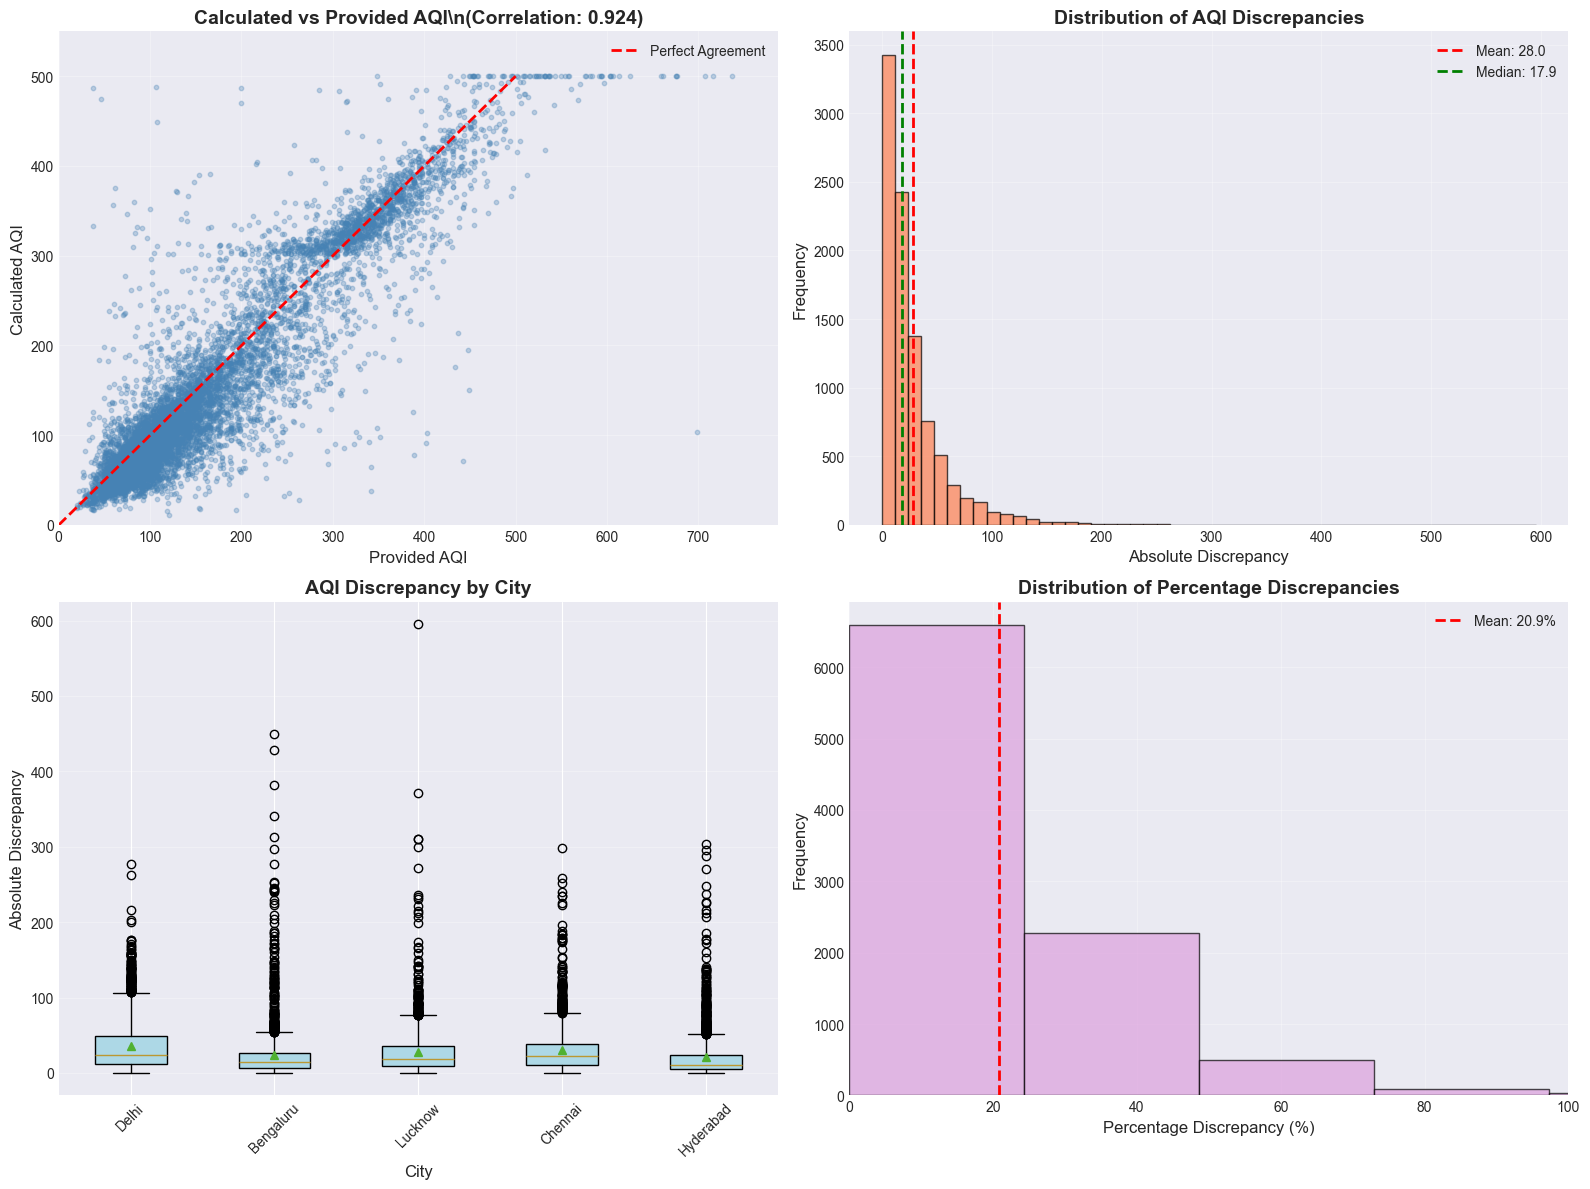


✓ Validation analysis completed


In [8]:
# Validation: Compare calculated vs provided AQI
print("=" * 80)
print("VALIDATION: CALCULATED vs PROVIDED AQI")
print("=" * 80)

# Filter for records with both provided AQI and calculated AQI
df_validation = df_enhanced[
    df_enhanced['AQI'].notna() & 
    df_enhanced['AQI_Calculated'].notna()
].copy()

print(f"\nRecords available for validation: {len(df_validation):,}")

if len(df_validation) > 0:
    # Calculate discrepancy
    df_validation['AQI_Discrepancy'] = abs(df_validation['AQI'] - df_validation['AQI_Calculated'])
    df_validation['AQI_Discrepancy_%'] = (df_validation['AQI_Discrepancy'] / df_validation['AQI'] * 100)
    
    # Overall statistics
    print(f"\n" + "-" * 80)
    print("OVERALL VALIDATION STATISTICS")
    print("-" * 80)
    print(f"Mean Absolute Error (MAE): {df_validation['AQI_Discrepancy'].mean():.2f}")
    print(f"Median Absolute Error: {df_validation['AQI_Discrepancy'].median():.2f}")
    print(f"Std Deviation of Error: {df_validation['AQI_Discrepancy'].std():.2f}")
    print(f"Max Discrepancy: {df_validation['AQI_Discrepancy'].max():.2f}")
    print(f"Mean Percentage Error: {df_validation['AQI_Discrepancy_%'].mean():.2f}%")
    
    # Correlation
    correlation = df_validation[['AQI', 'AQI_Calculated']].corr().iloc[0, 1]
    print(f"\nPearson Correlation: {correlation:.4f}")
    
    # RMSE
    rmse = np.sqrt(((df_validation['AQI'] - df_validation['AQI_Calculated']) ** 2).mean())
    print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
    
    # Accuracy within thresholds
    print(f"\n" + "-" * 80)
    print("ACCURACY THRESHOLDS")
    print("-" * 80)
    within_5 = (df_validation['AQI_Discrepancy'] <= 5).sum()
    within_10 = (df_validation['AQI_Discrepancy'] <= 10).sum()
    within_20 = (df_validation['AQI_Discrepancy'] <= 20).sum()
    within_50 = (df_validation['AQI_Discrepancy'] <= 50).sum()
    
    total = len(df_validation)
    print(f"Within ±5 AQI points:  {within_5:,} ({within_5/total*100:.1f}%)")
    print(f"Within ±10 AQI points: {within_10:,} ({within_10/total*100:.1f}%)")
    print(f"Within ±20 AQI points: {within_20:,} ({within_20/total*100:.1f}%)")
    print(f"Within ±50 AQI points: {within_50:,} ({within_50/total*100:.1f}%)")
    
    # By city
    print(f"\n" + "-" * 80)
    print("VALIDATION STATISTICS BY CITY")
    print("-" * 80)
    city_validation = df_validation.groupby('City').agg({
        'AQI_Discrepancy': ['mean', 'median', 'max'],
        'AQI_Calculated': 'count'
    }).round(2)
    city_validation.columns = ['Mean_Error', 'Median_Error', 'Max_Error', 'Count']
    print(city_validation)
    
    # Visualizations
    print(f"\n" + "=" * 80)
    print("VALIDATION VISUALIZATIONS")
    print("=" * 80)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Scatter plot: Calculated vs Provided
    axes[0, 0].scatter(df_validation['AQI'], df_validation['AQI_Calculated'], 
                       alpha=0.3, s=10, color='steelblue')
    axes[0, 0].plot([0, 500], [0, 500], 'r--', linewidth=2, label='Perfect Agreement')
    axes[0, 0].set_xlabel('Provided AQI', fontsize=12)
    axes[0, 0].set_ylabel('Calculated AQI', fontsize=12)
    axes[0, 0].set_title(f'Calculated vs Provided AQI\\n(Correlation: {correlation:.3f})', 
                         fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    axes[0, 0].set_xlim(0, df_validation['AQI'].max() + 50)
    axes[0, 0].set_ylim(0, df_validation['AQI_Calculated'].max() + 50)
    
    # 2. Histogram of discrepancies
    axes[0, 1].hist(df_validation['AQI_Discrepancy'], bins=50, color='coral', edgecolor='black', alpha=0.7)
    axes[0, 1].axvline(df_validation['AQI_Discrepancy'].mean(), color='red', 
                       linestyle='--', linewidth=2, label=f'Mean: {df_validation["AQI_Discrepancy"].mean():.1f}')
    axes[0, 1].axvline(df_validation['AQI_Discrepancy'].median(), color='green', 
                       linestyle='--', linewidth=2, label=f'Median: {df_validation["AQI_Discrepancy"].median():.1f}')
    axes[0, 1].set_xlabel('Absolute Discrepancy', fontsize=12)
    axes[0, 1].set_ylabel('Frequency', fontsize=12)
    axes[0, 1].set_title('Distribution of AQI Discrepancies', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # 3. Box plot by city
    city_data = [df_validation[df_validation['City'] == city]['AQI_Discrepancy'].values 
                 for city in target_cities]
    bp = axes[1, 0].boxplot(city_data, labels=target_cities, patch_artist=True, showmeans=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
    axes[1, 0].set_ylabel('Absolute Discrepancy', fontsize=12)
    axes[1, 0].set_xlabel('City', fontsize=12)
    axes[1, 0].set_title('AQI Discrepancy by City', fontsize=14, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # 4. Percentage error distribution
    axes[1, 1].hist(df_validation['AQI_Discrepancy_%'], bins=50, color='plum', edgecolor='black', alpha=0.7)
    axes[1, 1].axvline(df_validation['AQI_Discrepancy_%'].mean(), color='red', 
                       linestyle='--', linewidth=2, label=f'Mean: {df_validation["AQI_Discrepancy_%"].mean():.1f}%')
    axes[1, 1].set_xlabel('Percentage Discrepancy (%)', fontsize=12)
    axes[1, 1].set_ylabel('Frequency', fontsize=12)
    axes[1, 1].set_title('Distribution of Percentage Discrepancies', fontsize=14, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    axes[1, 1].set_xlim(0, min(100, df_validation['AQI_Discrepancy_%'].quantile(0.99)))
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Validation analysis completed")
else:
    print("\n⚠ No records available for validation")


AQI CATEGORY COMPARISON

Overall Category Agreement: 6,290 / 9,553 (65.8%)

--------------------------------------------------------------------------------
CATEGORY DISTRIBUTION COMPARISON
--------------------------------------------------------------------------------
              Actual_Count  Calculated_Count  Actual_%  Calculated_%
Good                   300               953      3.10         10.00
Moderate              3486              2884     36.50         30.20
Poor                  1094               734     11.50          7.70
Satisfactory          3292              3448     34.50         36.10
Severe                 362               296      3.80          3.10
Very Poor             1019              1238     10.70         13.00

--------------------------------------------------------------------------------
CONFUSION MATRIX
--------------------------------------------------------------------------------
                     Calc_Good  Calc_Satisfactory  Calc_Moderate 

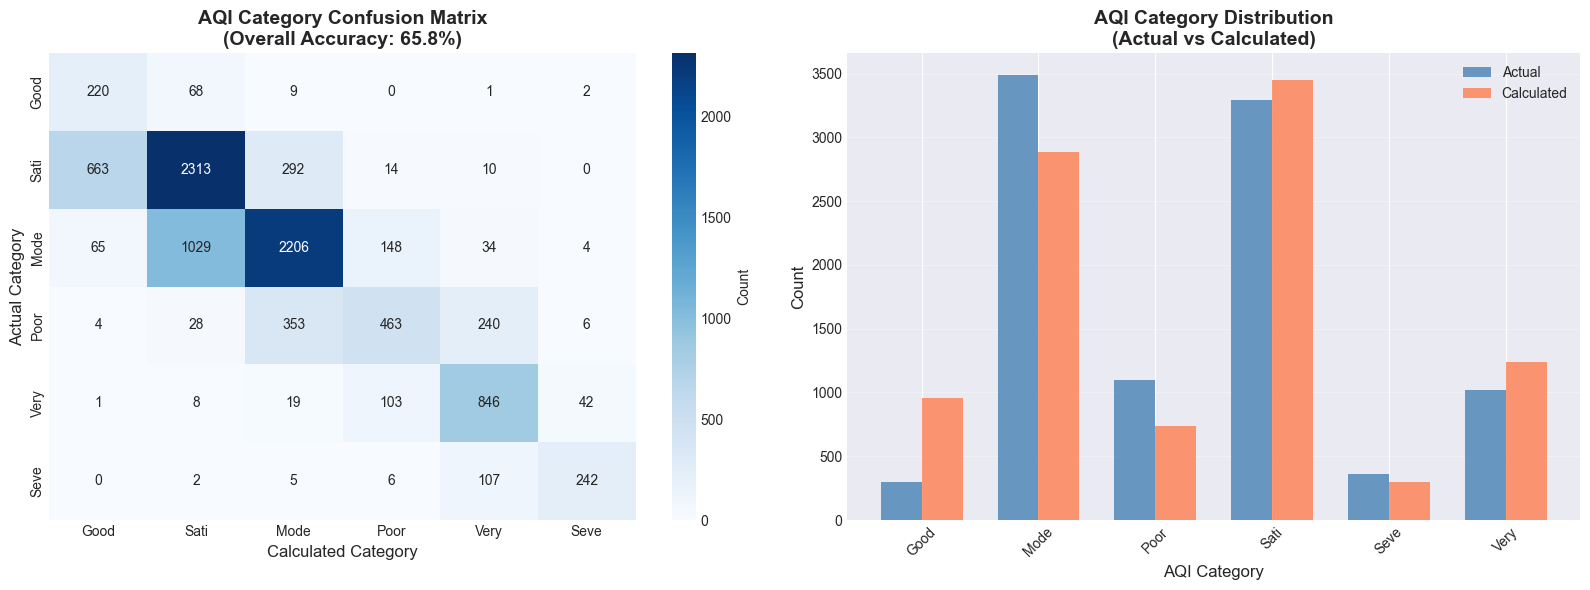


--------------------------------------------------------------------------------
CATEGORY MISMATCH ANALYSIS
--------------------------------------------------------------------------------

Total Mismatches: 3,263 (34.2%)

Top 5 Category Mismatches:
  Moderate → Satisfactory: 1,029 (10.8%)
  Satisfactory → Good: 663 (6.9%)
  Poor → Moderate: 353 (3.7%)
  Satisfactory → Moderate: 292 (3.1%)
  Poor → Very Poor: 240 (2.5%)

Average AQI Discrepancy for Category Mismatches: 49.34

✓ Category comparison analysis completed


In [9]:
# Category Comparison Analysis
print("\n" + "=" * 80)
print("AQI CATEGORY COMPARISON")
print("=" * 80)

if len(df_validation) > 0:
    # Derive actual AQI category from provided AQI values
    df_validation['AQI_Category_Actual'] = df_validation['AQI'].apply(get_aqi_category)
    
    # Compare categories
    category_comparison = df_validation[['AQI_Category_Actual', 'AQI_Category_Calculated']].copy()
    
    # Overall category agreement
    category_match = (category_comparison['AQI_Category_Actual'] == category_comparison['AQI_Category_Calculated']).sum()
    category_total = len(category_comparison)
    category_accuracy = category_match / category_total * 100
    
    print(f"\nOverall Category Agreement: {category_match:,} / {category_total:,} ({category_accuracy:.1f}%)")
    
    # Category distribution comparison
    print(f"\n" + "-" * 80)
    print("CATEGORY DISTRIBUTION COMPARISON")
    print("-" * 80)
    
    actual_dist = df_validation['AQI_Category_Actual'].value_counts().sort_index()
    calculated_dist = df_validation['AQI_Category_Calculated'].value_counts().sort_index()
    
    comparison_df = pd.DataFrame({
        'Actual_Count': actual_dist,
        'Calculated_Count': calculated_dist,
        'Actual_%': (actual_dist / category_total * 100).round(1),
        'Calculated_%': (calculated_dist / category_total * 100).round(1)
    })
    print(comparison_df)
    
    # Confusion matrix
    from sklearn.metrics import confusion_matrix, classification_report
    
    # Define category order
    category_order = ['Good', 'Satisfactory', 'Moderate', 'Poor', 'Very Poor', 'Severe']
    
    # Filter to only categories present in the data
    present_categories = sorted(set(df_validation['AQI_Category_Actual'].unique()) | 
                                 set(df_validation['AQI_Category_Calculated'].unique()),
                                key=lambda x: category_order.index(x) if x in category_order else 999)
    
    cm = confusion_matrix(df_validation['AQI_Category_Actual'], 
                          df_validation['AQI_Category_Calculated'],
                          labels=present_categories)
    
    print(f"\n" + "-" * 80)
    print("CONFUSION MATRIX")
    print("-" * 80)
    
    # Create confusion matrix DataFrame
    cm_df = pd.DataFrame(cm, 
                         index=[f'Actual_{cat}' for cat in present_categories],
                         columns=[f'Calc_{cat}' for cat in present_categories])
    print(cm_df)
    
    # Classification report
    print(f"\n" + "-" * 80)
    print("CLASSIFICATION REPORT")
    print("-" * 80)
    print(classification_report(df_validation['AQI_Category_Actual'], 
                                 df_validation['AQI_Category_Calculated'],
                                 labels=present_categories,
                                 target_names=present_categories,
                                 zero_division=0))
    
    # Visualizations
    print(f"\n" + "=" * 80)
    print("CATEGORY COMPARISON VISUALIZATIONS")
    print("=" * 80)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 1. Confusion Matrix Heatmap
    import seaborn as sns
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=[cat[:4] for cat in present_categories],
                yticklabels=[cat[:4] for cat in present_categories],
                ax=axes[0], cbar_kws={'label': 'Count'})
    axes[0].set_xlabel('Calculated Category', fontsize=12)
    axes[0].set_ylabel('Actual Category', fontsize=12)
    axes[0].set_title(f'AQI Category Confusion Matrix\n(Overall Accuracy: {category_accuracy:.1f}%)', 
                     fontsize=14, fontweight='bold')
    
    # 2. Category Distribution Comparison
    x = np.arange(len(comparison_df))
    width = 0.35
    
    axes[1].bar(x - width/2, comparison_df['Actual_Count'], width, 
               label='Actual', color='steelblue', alpha=0.8)
    axes[1].bar(x + width/2, comparison_df['Calculated_Count'], width,
               label='Calculated', color='coral', alpha=0.8)
    
    axes[1].set_xlabel('AQI Category', fontsize=12)
    axes[1].set_ylabel('Count', fontsize=12)
    axes[1].set_title('AQI Category Distribution\n(Actual vs Calculated)', 
                     fontsize=14, fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels([cat[:4] for cat in comparison_df.index], rotation=45)
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Category mismatch analysis
    print(f"\n" + "-" * 80)
    print("CATEGORY MISMATCH ANALYSIS")
    print("-" * 80)
    
    mismatches = df_validation[df_validation['AQI_Category_Actual'] != df_validation['AQI_Category_Calculated']].copy()
    
    if len(mismatches) > 0:
        print(f"\nTotal Mismatches: {len(mismatches):,} ({len(mismatches)/category_total*100:.1f}%)")
        print(f"\nTop 5 Category Mismatches:")
        mismatch_pairs = mismatches.groupby(['AQI_Category_Actual', 'AQI_Category_Calculated']).size().sort_values(ascending=False).head(5)
        for (actual, calc), count in mismatch_pairs.items():
            print(f"  {actual} → {calc}: {count:,} ({count/category_total*100:.1f}%)")
        
        # Average discrepancy for mismatches
        print(f"\nAverage AQI Discrepancy for Category Mismatches: {mismatches['AQI_Discrepancy'].mean():.2f}")
    else:
        print("\nNo category mismatches found!")
    
    print("\n✓ Category comparison analysis completed")
else:
    print("\n⚠ No validation data available for category comparison")

---

## 8. Prominent Pollutant Analysis <a id='prominent'></a>

Analyze which pollutants are driving AQI levels in each city.

PROMINENT POLLUTANT ANALYSIS

Records with identified prominent pollutant: 9,624

--------------------------------------------------------------------------------
OVERALL PROMINENT POLLUTANT DISTRIBUTION
--------------------------------------------------------------------------------
PM2.5   : 4,926 (51.2%)
PM10    : 3,299 (34.3%)
CO      : 1,023 (10.6%)
O3      : 249 (2.6%)
NO2     : 113 (1.2%)
NH3     : 13 (0.1%)
SO2     : 1 (0.0%)

--------------------------------------------------------------------------------
PROMINENT POLLUTANT BY CITY
--------------------------------------------------------------------------------

Delhi:
  PM2.5   : 1,079 (53.8%)
  PM10    : 827 (41.2%)
  CO      : 69 (3.4%)
  NO2     : 25 (1.2%)
  O3      : 7 (0.3%)

Bengaluru:
  PM10    : 1,234 (64.1%)
  CO      : 328 (17.0%)
  PM2.5   : 293 (15.2%)
  O3      : 47 (2.4%)
  NO2     : 23 (1.2%)

Lucknow:
  PM2.5   : 1,570 (82.3%)
  CO      : 304 (15.9%)
  O3      : 19 (1.0%)
  NO2     : 14 (0.7%)

Chennai:
  PM

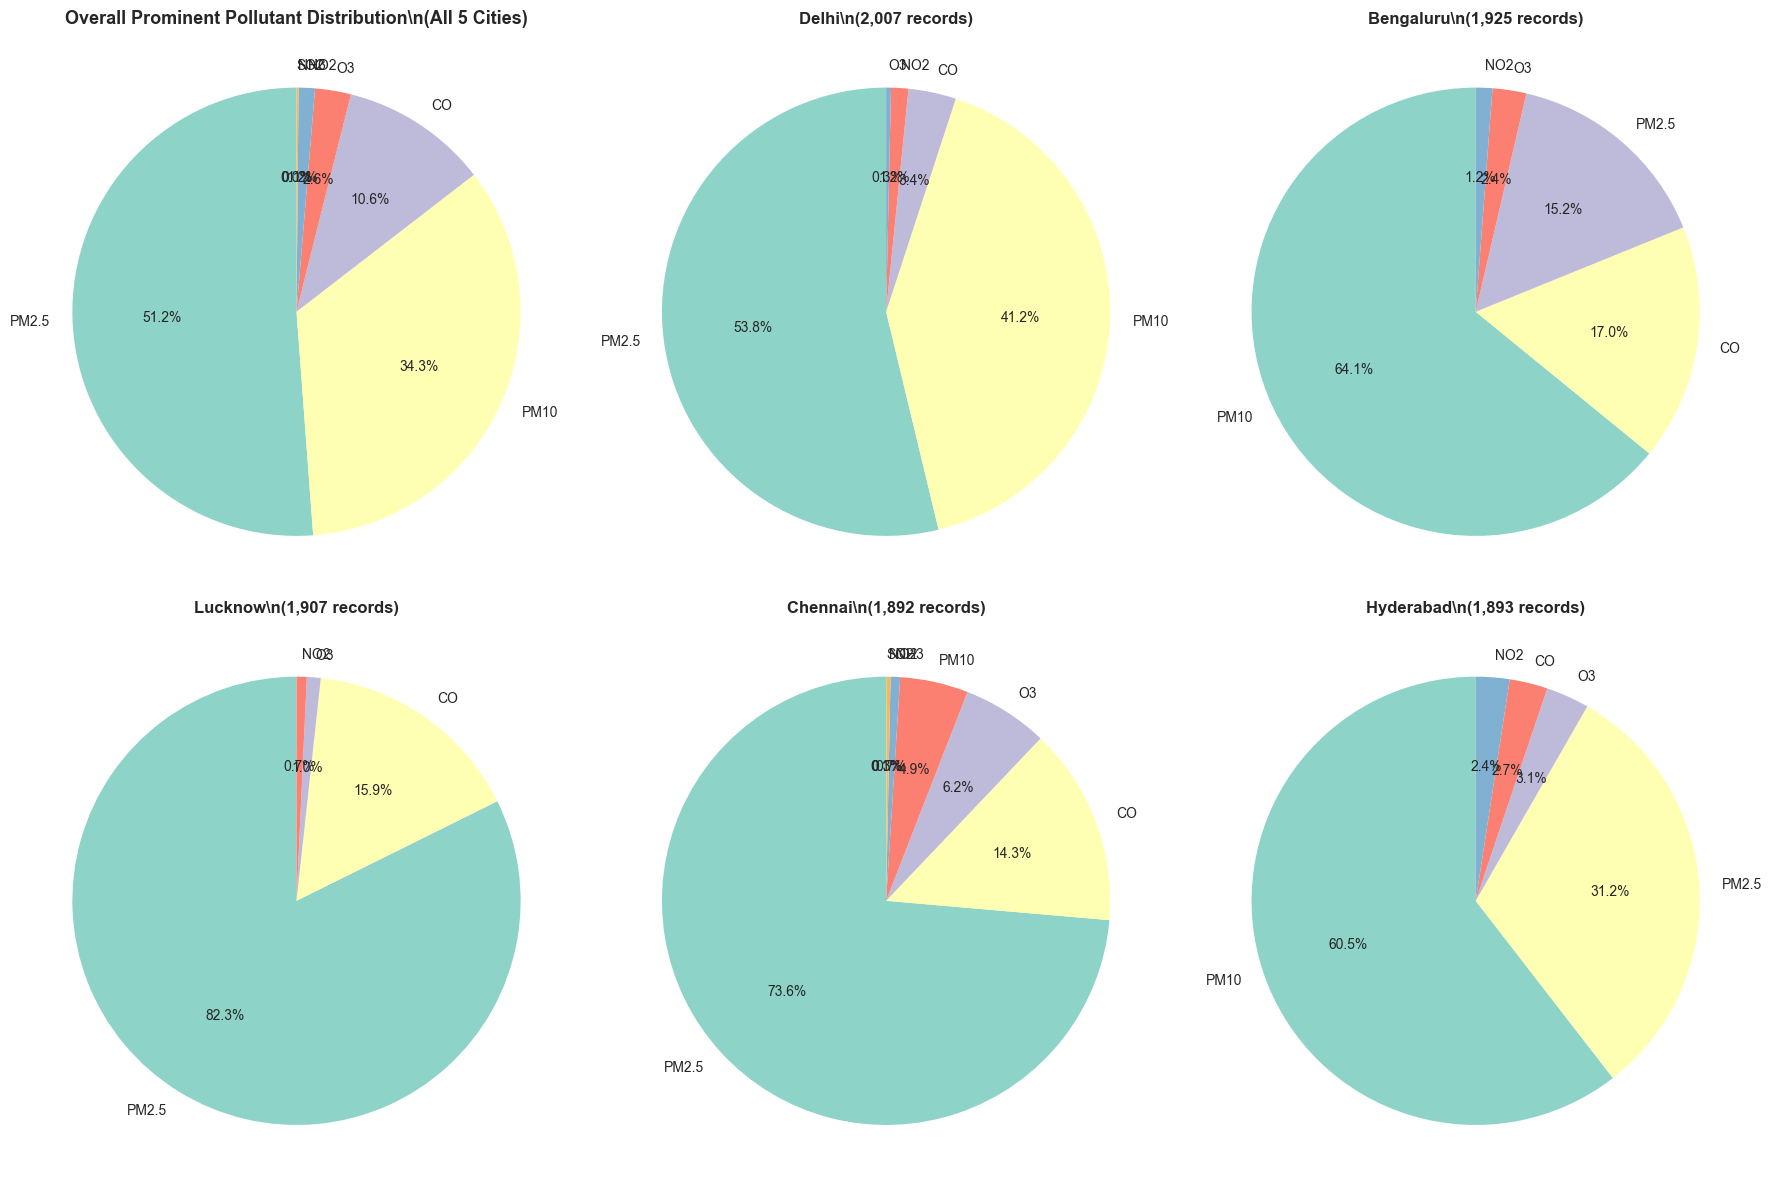


✓ Prominent pollutant analysis completed


In [10]:
# Prominent Pollutant Analysis
print("=" * 80)
print("PROMINENT POLLUTANT ANALYSIS")
print("=" * 80)

# Filter for records with calculated AQI
df_prominent = df_enhanced[df_enhanced['Prominent_Pollutant'].notna()].copy()

print(f"\nRecords with identified prominent pollutant: {len(df_prominent):,}")

if len(df_prominent) > 0:
    # Overall distribution
    print(f"\n" + "-" * 80)
    print("OVERALL PROMINENT POLLUTANT DISTRIBUTION")
    print("-" * 80)
    prominent_counts = df_prominent['Prominent_Pollutant'].value_counts()
    for pollutant, count in prominent_counts.items():
        pct = count / len(df_prominent) * 100
        print(f"{pollutant:8s}: {count:,} ({pct:.1f}%)")
    
    # By city
    print(f"\n" + "-" * 80)
    print("PROMINENT POLLUTANT BY CITY")
    print("-" * 80)
    for city in target_cities:
        city_data = df_prominent[df_prominent['City'] == city]
        if len(city_data) > 0:
            print(f"\n{city}:")
            city_prominent = city_data['Prominent_Pollutant'].value_counts()
            for pollutant, count in city_prominent.items():
                pct = count / len(city_data) * 100
                print(f"  {pollutant:8s}: {count:,} ({pct:.1f}%)")
    
    # Visualizations
    print(f"\n" + "=" * 80)
    print("PROMINENT POLLUTANT VISUALIZATIONS")
    print("=" * 80)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # Overall pie chart
    colors_prominent = plt.cm.Set3(range(len(prominent_counts)))
    axes[0].pie(prominent_counts.values, labels=prominent_counts.index, autopct='%1.1f%%',
                colors=colors_prominent, startangle=90)
    axes[0].set_title('Overall Prominent Pollutant Distribution\\n(All 5 Cities)', 
                      fontsize=13, fontweight='bold')
    
    # Individual city pie charts
    for idx, city in enumerate(target_cities, start=1):
        city_data = df_prominent[df_prominent['City'] == city]
        if len(city_data) > 0:
            city_prominent = city_data['Prominent_Pollutant'].value_counts()
            axes[idx].pie(city_prominent.values, labels=city_prominent.index, autopct='%1.1f%%',
                         colors=colors_prominent[:len(city_prominent)], startangle=90)
            axes[idx].set_title(f'{city}\\n({len(city_data):,} records)', 
                               fontsize=12, fontweight='bold')
        else:
            axes[idx].text(0.5, 0.5, 'No Data', ha='center', va='center', fontsize=14)
            axes[idx].set_title(f'{city}', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Prominent pollutant analysis completed")
else:
    print("\n⚠ No records with prominent pollutant identified")

---

## 9. Summary & Export <a id='summary'></a>

Summarize findings and export the enhanced dataset with calculated AQI values.

In [11]:
# Summary Report
print("=" * 80)
print("CPCB AQI CALCULATION - SUMMARY REPORT")
print("=" * 80)

print("\n1. DATASET OVERVIEW")
print(f"   - Total Records: {len(df_enhanced):,}")
print(f"   - Cities: {', '.join(target_cities)}")
print(f"   - Date Range: {df_enhanced['Date'].min().date()} to {df_enhanced['Date'].max().date()}")

print("\n2. DATA SUFFICIENCY")
sufficient_count = df_enhanced['Data_Sufficient'].sum()
insufficient_count = len(df_enhanced) - sufficient_count
print(f"   - Sufficient Data: {sufficient_count:,} ({sufficient_count/len(df_enhanced)*100:.1f}%)")
print(f"   - Insufficient Data: {insufficient_count:,} ({insufficient_count/len(df_enhanced)*100:.1f}%)")

print("\n3. AQI STATUS")
provided_aqi = df_enhanced['AQI'].notna().sum()
calculated_aqi = df_enhanced['AQI_Calculated'].notna().sum()
missing_aqi = df_enhanced['AQI'].isna().sum()
filled_aqi = (df_enhanced['AQI'].isna() & df_enhanced['AQI_Calculated'].notna()).sum()

print(f"   - Records with Provided AQI: {provided_aqi:,} ({provided_aqi/len(df_enhanced)*100:.1f}%)")
print(f"   - Records with Calculated AQI: {calculated_aqi:,} ({calculated_aqi/len(df_enhanced)*100:.1f}%)")
print(f"   - Records with Missing AQI: {missing_aqi:,} ({missing_aqi/len(df_enhanced)*100:.1f}%)")
print(f"   - Missing AQI Filled by Calculation: {filled_aqi:,}")

if len(df_validation) > 0:
    print("\n4. VALIDATION METRICS")
    print(f"   - Mean Absolute Error (MAE): {df_validation['AQI_Discrepancy'].mean():.2f}")
    print(f"   - Root Mean Square Error (RMSE): {rmse:.2f}")
    print(f"   - Pearson Correlation: {correlation:.4f}")
    print(f"   - Within ±10 AQI points: {(df_validation['AQI_Discrepancy'] <= 10).sum():,} ({(df_validation['AQI_Discrepancy'] <= 10).sum()/len(df_validation)*100:.1f}%)")

if len(df_prominent) > 0:
    print("\n5. TOP PROMINENT POLLUTANTS")
    top_prominent = df_prominent['Prominent_Pollutant'].value_counts().head(3)
    for i, (pollutant, count) in enumerate(top_prominent.items(), 1):
        print(f"   {i}. {pollutant}: {count:,} ({count/len(df_prominent)*100:.1f}%)")

print("\n6. KEY INSIGHTS")
print(f"   - CPCB AQI calculation successfully implemented")
print(f"   - {sufficient_count:,} records have sufficient data (3+ pollutants, PM2.5 or PM10)")
if len(df_validation) > 0 and correlation > 0.9:
    print(f"   - Strong correlation (r={correlation:.3f}) validates implementation")
print(f"   - {filled_aqi:,} missing AQI values filled through calculation")

print("\n" + "=" * 80)
print("✓ ANALYSIS COMPLETE")
print("=" * 80)

CPCB AQI CALCULATION - SUMMARY REPORT

1. DATASET OVERVIEW
   - Total Records: 10,042
   - Cities: Delhi, Bengaluru, Lucknow, Chennai, Hyderabad
   - Date Range: 2015-01-01 to 2020-07-01

2. DATA SUFFICIENCY
   - Sufficient Data: 9,624 (95.8%)
   - Insufficient Data: 418 (4.2%)

3. AQI STATUS
   - Records with Provided AQI: 9,566 (95.3%)
   - Records with Calculated AQI: 9,624 (95.8%)
   - Records with Missing AQI: 476 (4.7%)
   - Missing AQI Filled by Calculation: 71

4. VALIDATION METRICS
   - Mean Absolute Error (MAE): 27.97
   - Root Mean Square Error (RMSE): 43.98
   - Pearson Correlation: 0.9238
   - Within ±10 AQI points: 2,912 (30.5%)

5. TOP PROMINENT POLLUTANTS
   1. PM2.5: 4,926 (51.2%)
   2. PM10: 3,299 (34.3%)
   3. CO: 1,023 (10.6%)

6. KEY INSIGHTS
   - CPCB AQI calculation successfully implemented
   - 9,624 records have sufficient data (3+ pollutants, PM2.5 or PM10)
   - Strong correlation (r=0.924) validates implementation
   - 71 missing AQI values filled through cal

---

## 10. Hourly Data Analysis & Improved AQI Calculation <a id='hourly'></a>

**Objective:** Calculate AQI using proper rolling averages from hourly data as per CPCB guidelines:
- 24-hour rolling average for PM2.5, PM10, NO2, SO2, NH3
- 8-hour rolling average for CO, O3

In [13]:
# Load hourly data
print("=" * 80)
print("LOADING HOURLY DATA")
print("=" * 80)

hourly_data_path = './Data/city_hour.csv'
df_hourly = pd.read_csv(hourly_data_path)

# Parse datetime
df_hourly['Datetime'] = pd.to_datetime(df_hourly['Datetime'])

# Filter for the same 5 cities
df_hourly_filtered = df_hourly[df_hourly['City'].isin(target_cities)].copy()

print(f"\nHourly dataset loaded successfully!")
print(f"Shape: {df_hourly_filtered.shape}")
print(f"Date range: {df_hourly_filtered['Datetime'].min()} to {df_hourly_filtered['Datetime'].max()}")
print(f"\nColumns: {df_hourly_filtered.columns.tolist()}")

# Data overview
print(f"\n" + "=" * 80)
print("HOURLY DATA OVERVIEW")
print("=" * 80)
print(df_hourly_filtered.head())

# Check data availability by city
print(f"\n" + "=" * 80)
print("RECORDS PER CITY (HOURLY DATA)")
print("=" * 80)
city_counts_hourly = df_hourly_filtered['City'].value_counts().sort_index()
print(city_counts_hourly)

# Check for duplicates
print(f"\n" + "=" * 80)
print("DATA QUALITY CHECKS")
print("=" * 80)
duplicates = df_hourly_filtered.duplicated(subset=['City', 'Datetime']).sum()
print(f"Duplicate records (City + Datetime): {duplicates:,}")

# Missing values
print(f"\nMissing values per column:")
missing_hourly = df_hourly_filtered.isnull().sum()
missing_pct_hourly = (missing_hourly / len(df_hourly_filtered) * 100).round(1)
for col, miss, pct in zip(missing_hourly.index, missing_hourly.values, missing_pct_hourly.values):
    if miss > 0:
        print(f"  {col}: {miss:,} ({pct}%)")

print("\n✓ Hourly data loaded and explored")

LOADING HOURLY DATA

Hourly dataset loaded successfully!
Shape: (240875, 16)
Date range: 2015-01-01 01:00:00 to 2020-07-01 00:00:00

Columns: ['City', 'Datetime', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket']

HOURLY DATA OVERVIEW
             City            Datetime  PM2.5  PM10   NO   NO2  NOx   NH3   CO  \
102925  Bengaluru 2015-01-01 01:00:00    NaN   NaN 2.04 12.40 7.58 19.10 0.19   
102926  Bengaluru 2015-01-01 02:00:00    NaN   NaN 2.20 12.11 7.54 17.81 0.21   
102927  Bengaluru 2015-01-01 03:00:00    NaN   NaN 1.66 10.82 6.52 17.42 0.30   
102928  Bengaluru 2015-01-01 04:00:00    NaN   NaN 1.92 10.32 6.46 16.86 0.13   
102929  Bengaluru 2015-01-01 05:00:00    NaN   NaN 1.94  9.82 6.22 16.35 0.15   

        SO2    O3  Benzene  Toluene  Xylene  AQI AQI_Bucket  
102925 4.05 12.41     0.56     3.43     NaN  NaN        NaN  
102926 4.23 12.13      NaN     4.54     NaN  NaN        NaN  
102927 4.28 13.13      NaN

In [14]:
# Calculate rolling averages per CPCB guidelines
print("=" * 80)
print("CALCULATING ROLLING AVERAGES (CPCB GUIDELINES)")
print("=" * 80)

# Sort by city and datetime for proper rolling calculation
df_hourly_filtered = df_hourly_filtered.sort_values(['City', 'Datetime']).reset_index(drop=True)

# Define pollutants and their averaging periods
pollutants_24h = ['PM2.5', 'PM10', 'NO2', 'SO2', 'NH3']  # 24-hour average
pollutants_8h = ['CO', 'O3']  # 8-hour average

print("\nCalculating rolling averages...")
print("  - 24-hour rolling average for: PM2.5, PM10, NO2, SO2, NH3")
print("  - 8-hour rolling average for: CO, O3")

# Create a new dataframe for rolling averages
df_hourly_rolling = []

for city in target_cities:
    print(f"\nProcessing {city}...")
    city_data = df_hourly_filtered[df_hourly_filtered['City'] == city].copy()
    
    # Calculate 24-hour rolling averages (need at least 16 hours of data out of 24, per CPCB)
    for pollutant in pollutants_24h:
        if pollutant in city_data.columns:
            # Rolling average with minimum 16 valid values (67% data availability)
            city_data[f'{pollutant}_24h'] = city_data[pollutant].rolling(
                window=24, 
                min_periods=16,
                center=False
            ).mean()
    
    # Calculate 8-hour rolling averages (need at least 6 hours of data out of 8, per CPCB)
    for pollutant in pollutants_8h:
        if pollutant in city_data.columns:
            # Rolling average with minimum 6 valid values (75% data availability)
            city_data[f'{pollutant}_8h'] = city_data[pollutant].rolling(
                window=8,
                min_periods=6,
                center=False
            ).mean()
    
    df_hourly_rolling.append(city_data)

# Combine all cities
df_hourly_rolling = pd.concat(df_hourly_rolling, ignore_index=True)

print("\n✓ Rolling averages calculated")

# Show sample of rolling averages
print(f"\n" + "=" * 80)
print("SAMPLE OF ROLLING AVERAGES")
print("=" * 80)

sample_cols = ['City', 'Datetime', 'PM2.5', 'PM2.5_24h', 'CO', 'CO_8h', 'AQI']
available_sample_cols = [col for col in sample_cols if col in df_hourly_rolling.columns]
print(df_hourly_rolling[available_sample_cols].iloc[100:110])

# Check completeness of rolling averages
print(f"\n" + "=" * 80)
print("ROLLING AVERAGE COMPLETENESS")
print("=" * 80)

for pollutant in pollutants_24h:
    if pollutant in df_hourly_rolling.columns:
        col_name = f'{pollutant}_24h'
        if col_name in df_hourly_rolling.columns:
            available = df_hourly_rolling[col_name].notna().sum()
            total = len(df_hourly_rolling)
            print(f"{col_name:15s}: {available:,} / {total:,} ({available/total*100:.1f}%)")

for pollutant in pollutants_8h:
    if pollutant in df_hourly_rolling.columns:
        col_name = f'{pollutant}_8h'
        if col_name in df_hourly_rolling.columns:
            available = df_hourly_rolling[col_name].notna().sum()
            total = len(df_hourly_rolling)
            print(f"{col_name:15s}: {available:,} / {total:,} ({available/total*100:.1f}%)")

CALCULATING ROLLING AVERAGES (CPCB GUIDELINES)

Calculating rolling averages...
  - 24-hour rolling average for: PM2.5, PM10, NO2, SO2, NH3
  - 8-hour rolling average for: CO, O3

Processing Delhi...

Processing Bengaluru...

Processing Lucknow...

Processing Chennai...

Processing Hyderabad...

✓ Rolling averages calculated

SAMPLE OF ROLLING AVERAGES
      City            Datetime  PM2.5  PM2.5_24h    CO  CO_8h    AQI
100  Delhi 2015-01-05 05:00:00 143.68     145.89  9.38   9.94 320.00
101  Delhi 2015-01-05 06:00:00 152.73     147.86 10.39  10.65 322.00
102  Delhi 2015-01-05 07:00:00 151.81     148.66  7.28  11.02 322.00
103  Delhi 2015-01-05 08:00:00 150.26     150.53  8.51  10.94 324.00
104  Delhi 2015-01-05 09:00:00 151.12     152.10  8.54  10.26 324.00
105  Delhi 2015-01-05 10:00:00 154.89     154.33  8.05   9.63 326.00
106  Delhi 2015-01-05 11:00:00 153.87     156.53  7.97   9.06 328.00
107  Delhi 2015-01-05 12:00:00 164.75     159.15  7.31   8.43 330.00
108  Delhi 2015-01-05 13

In [15]:
# Calculate AQI from rolling averages
print("=" * 80)
print("CALCULATING AQI FROM ROLLING AVERAGES")
print("=" * 80)

def calculate_aqi_from_hourly(row):
    """
    Calculate AQI from hourly rolling averages using CPCB guidelines.
    """
    # Prepare a row with rolling averages in the expected format
    pollutant_row = pd.Series({
        'PM2.5': row.get('PM2.5_24h', np.nan),
        'PM10': row.get('PM10_24h', np.nan),
        'NO2': row.get('NO2_24h', np.nan),
        'SO2': row.get('SO2_24h', np.nan),
        'NH3': row.get('NH3_24h', np.nan),
        'CO': row.get('CO_8h', np.nan),
        'O3': row.get('O3_8h', np.nan)
    })
    
    # Use the existing comprehensive AQI calculation function
    return calculate_aqi_comprehensive(pollutant_row)

print("\nApplying CPCB AQI calculation to rolling averages...")
print("This may take a few minutes for large datasets...")

# Calculate AQI for each hour
aqi_hourly_results = df_hourly_rolling.apply(calculate_aqi_from_hourly, axis=1)

# Convert results to DataFrame
aqi_hourly_df = pd.DataFrame(aqi_hourly_results.tolist())

# Combine with original hourly data
df_hourly_enhanced = pd.concat([df_hourly_rolling.reset_index(drop=True), aqi_hourly_df], axis=1)

print("\n✓ AQI calculation completed for hourly data")

# Data sufficiency statistics
print(f"\n" + "=" * 80)
print("HOURLY DATA - AQI CALCULATION STATISTICS")
print("=" * 80)

total_hourly = len(df_hourly_enhanced)
sufficient_hourly = df_hourly_enhanced['Data_Sufficient'].sum()
calculated_aqi_hourly = df_hourly_enhanced['AQI_Calculated'].notna().sum()

print(f"\nTotal Hourly Records: {total_hourly:,}")
print(f"  ✓ Sufficient Data: {sufficient_hourly:,} ({sufficient_hourly/total_hourly*100:.1f}%)")
print(f"  ✓ AQI Calculated: {calculated_aqi_hourly:,} ({calculated_aqi_hourly/total_hourly*100:.1f}%)")

# Show sample results
print(f"\n" + "=" * 80)
print("SAMPLE RESULTS")
print("=" * 80)
sample_display = df_hourly_enhanced[['City', 'Datetime', 'AQI', 'AQI_Calculated', 
                                       'AQI_Category_Calculated', 'Prominent_Pollutant',
                                       'Data_Sufficient']].iloc[200:210]
print(sample_display)

CALCULATING AQI FROM ROLLING AVERAGES

Applying CPCB AQI calculation to rolling averages...
This may take a few minutes for large datasets...

✓ AQI calculation completed for hourly data

HOURLY DATA - AQI CALCULATION STATISTICS

Total Hourly Records: 240,875
  ✓ Sufficient Data: 227,582 (94.5%)
  ✓ AQI Calculated: 227,582 (94.5%)

SAMPLE RESULTS
      City            Datetime    AQI  AQI_Calculated AQI_Category_Calculated  \
200  Delhi 2015-01-09 09:00:00 375.00          372.78               Very Poor   
201  Delhi 2015-01-09 10:00:00 377.00          370.72               Very Poor   
202  Delhi 2015-01-09 11:00:00 376.00          367.75               Very Poor   
203  Delhi 2015-01-09 12:00:00 378.00          366.41               Very Poor   
204  Delhi 2015-01-09 13:00:00 378.00          364.09               Very Poor   
205  Delhi 2015-01-09 14:00:00 381.00          363.37               Very Poor   
206  Delhi 2015-01-09 15:00:00 381.00          362.40               Very Poor   
207

VALIDATION: HOURLY CALCULATED AQI vs PROVIDED AQI

Records available for validation: 227,274

--------------------------------------------------------------------------------
OVERALL VALIDATION STATISTICS (HOURLY DATA)
--------------------------------------------------------------------------------
Mean Absolute Error (MAE): 22.57
Median Absolute Error: 11.71
Std Deviation of Error: 33.51
Max Discrepancy: 468.25
Mean Percentage Error: 16.21%

Pearson Correlation: 0.9416
Root Mean Square Error (RMSE): 40.40

--------------------------------------------------------------------------------
ACCURACY THRESHOLDS
--------------------------------------------------------------------------------
Within ±5 AQI points:  73,552 (32.4%)
Within ±10 AQI points: 104,865 (46.1%)
Within ±20 AQI points: 148,633 (65.4%)
Within ±50 AQI points: 201,237 (88.5%)

COMPARISON: HOURLY vs DAILY DATA RESULTS
        Metric Daily_Data Hourly_Data
           MAE      27.97       22.57
          RMSE      43.98       

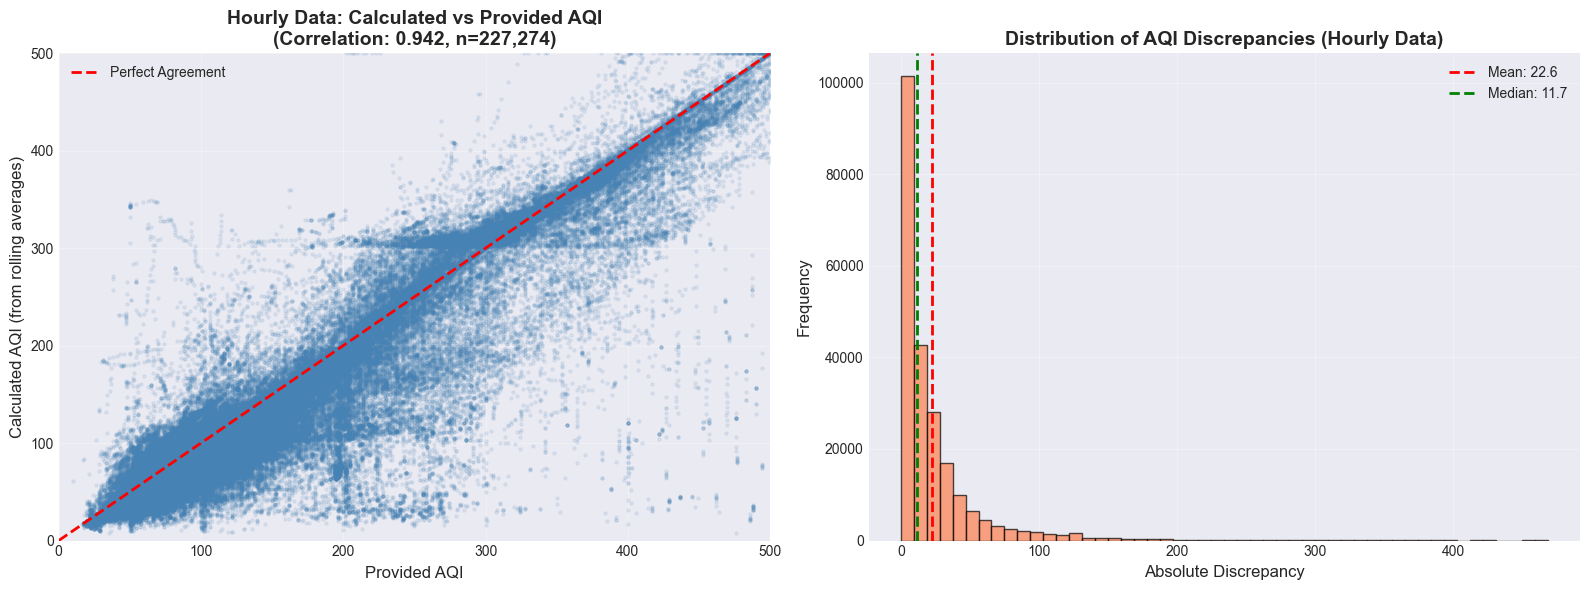


✓ Hourly data validation completed


In [16]:
# Validation: Hourly AQI vs Provided AQI
print("=" * 80)
print("VALIDATION: HOURLY CALCULATED AQI vs PROVIDED AQI")
print("=" * 80)

# Filter for records with both provided and calculated AQI
df_hourly_validation = df_hourly_enhanced[
    df_hourly_enhanced['AQI'].notna() & 
    df_hourly_enhanced['AQI_Calculated'].notna()
].copy()

print(f"\nRecords available for validation: {len(df_hourly_validation):,}")

if len(df_hourly_validation) > 0:
    # Calculate discrepancy
    df_hourly_validation['AQI_Discrepancy'] = abs(df_hourly_validation['AQI'] - df_hourly_validation['AQI_Calculated'])
    df_hourly_validation['AQI_Discrepancy_%'] = (df_hourly_validation['AQI_Discrepancy'] / df_hourly_validation['AQI'] * 100)
    
    # Overall statistics
    print(f"\n" + "-" * 80)
    print("OVERALL VALIDATION STATISTICS (HOURLY DATA)")
    print("-" * 80)
    print(f"Mean Absolute Error (MAE): {df_hourly_validation['AQI_Discrepancy'].mean():.2f}")
    print(f"Median Absolute Error: {df_hourly_validation['AQI_Discrepancy'].median():.2f}")
    print(f"Std Deviation of Error: {df_hourly_validation['AQI_Discrepancy'].std():.2f}")
    print(f"Max Discrepancy: {df_hourly_validation['AQI_Discrepancy'].max():.2f}")
    print(f"Mean Percentage Error: {df_hourly_validation['AQI_Discrepancy_%'].mean():.2f}%")
    
    # Correlation
    correlation_hourly = df_hourly_validation[['AQI', 'AQI_Calculated']].corr().iloc[0, 1]
    print(f"\nPearson Correlation: {correlation_hourly:.4f}")
    
    # RMSE
    rmse_hourly = np.sqrt(((df_hourly_validation['AQI'] - df_hourly_validation['AQI_Calculated']) ** 2).mean())
    print(f"Root Mean Square Error (RMSE): {rmse_hourly:.2f}")
    
    # Accuracy within thresholds
    print(f"\n" + "-" * 80)
    print("ACCURACY THRESHOLDS")
    print("-" * 80)
    within_5_hourly = (df_hourly_validation['AQI_Discrepancy'] <= 5).sum()
    within_10_hourly = (df_hourly_validation['AQI_Discrepancy'] <= 10).sum()
    within_20_hourly = (df_hourly_validation['AQI_Discrepancy'] <= 20).sum()
    within_50_hourly = (df_hourly_validation['AQI_Discrepancy'] <= 50).sum()
    
    total_hourly_val = len(df_hourly_validation)
    print(f"Within ±5 AQI points:  {within_5_hourly:,} ({within_5_hourly/total_hourly_val*100:.1f}%)")
    print(f"Within ±10 AQI points: {within_10_hourly:,} ({within_10_hourly/total_hourly_val*100:.1f}%)")
    print(f"Within ±20 AQI points: {within_20_hourly:,} ({within_20_hourly/total_hourly_val*100:.1f}%)")
    print(f"Within ±50 AQI points: {within_50_hourly:,} ({within_50_hourly/total_hourly_val*100:.1f}%)")
    
    # Comparison with daily data results
    print(f"\n" + "=" * 80)
    print("COMPARISON: HOURLY vs DAILY DATA RESULTS")
    print("=" * 80)
    
    comparison_table = pd.DataFrame({
        'Metric': ['MAE', 'RMSE', 'Correlation', 'Within ±10 AQI', 'Within ±20 AQI'],
        'Daily_Data': [
            f"{df_validation['AQI_Discrepancy'].mean():.2f}",
            f"{rmse:.2f}",
            f"{correlation:.4f}",
            f"{(df_validation['AQI_Discrepancy'] <= 10).sum()/len(df_validation)*100:.1f}%",
            f"{(df_validation['AQI_Discrepancy'] <= 20).sum()/len(df_validation)*100:.1f}%"
        ],
        'Hourly_Data': [
            f"{df_hourly_validation['AQI_Discrepancy'].mean():.2f}",
            f"{rmse_hourly:.2f}",
            f"{correlation_hourly:.4f}",
            f"{within_10_hourly/total_hourly_val*100:.1f}%",
            f"{within_20_hourly/total_hourly_val*100:.1f}%"
        ]
    })
    print(comparison_table.to_string(index=False))
    
    # Determine which is better
    print(f"\n" + "-" * 80)
    print("ANALYSIS")
    print("-" * 80)
    
    if correlation_hourly > correlation:
        print(f"✓ Hourly data shows BETTER correlation: {correlation_hourly:.4f} vs {correlation:.4f}")
    else:
        print(f"✗ Daily data shows better correlation: {correlation:.4f} vs {correlation_hourly:.4f}")
    
    if df_hourly_validation['AQI_Discrepancy'].mean() < df_validation['AQI_Discrepancy'].mean():
        print(f"✓ Hourly data shows LOWER MAE: {df_hourly_validation['AQI_Discrepancy'].mean():.2f} vs {df_validation['AQI_Discrepancy'].mean():.2f}")
    else:
        print(f"✗ Daily data shows lower MAE: {df_validation['AQI_Discrepancy'].mean():.2f} vs {df_hourly_validation['AQI_Discrepancy'].mean():.2f}")
    
    # Visualization
    print(f"\n" + "=" * 80)
    print("VALIDATION VISUALIZATION (HOURLY DATA)")
    print("=" * 80)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 1. Scatter plot: Calculated vs Provided
    axes[0].scatter(df_hourly_validation['AQI'], df_hourly_validation['AQI_Calculated'], 
                   alpha=0.1, s=5, color='steelblue')
    axes[0].plot([0, 500], [0, 500], 'r--', linewidth=2, label='Perfect Agreement')
    axes[0].set_xlabel('Provided AQI', fontsize=12)
    axes[0].set_ylabel('Calculated AQI (from rolling averages)', fontsize=12)
    axes[0].set_title(f'Hourly Data: Calculated vs Provided AQI\n(Correlation: {correlation_hourly:.3f}, n={len(df_hourly_validation):,})', 
                     fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    axes[0].set_xlim(0, min(500, df_hourly_validation['AQI'].max() + 50))
    axes[0].set_ylim(0, min(500, df_hourly_validation['AQI_Calculated'].max() + 50))
    
    # 2. Histogram of discrepancies
    axes[1].hist(df_hourly_validation['AQI_Discrepancy'], bins=50, color='coral', edgecolor='black', alpha=0.7)
    axes[1].axvline(df_hourly_validation['AQI_Discrepancy'].mean(), color='red', 
                   linestyle='--', linewidth=2, label=f'Mean: {df_hourly_validation["AQI_Discrepancy"].mean():.1f}')
    axes[1].axvline(df_hourly_validation['AQI_Discrepancy'].median(), color='green', 
                   linestyle='--', linewidth=2, label=f'Median: {df_hourly_validation["AQI_Discrepancy"].median():.1f}')
    axes[1].set_xlabel('Absolute Discrepancy', fontsize=12)
    axes[1].set_ylabel('Frequency', fontsize=12)
    axes[1].set_title('Distribution of AQI Discrepancies (Hourly Data)', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Hourly data validation completed")
else:
    print("\n⚠ No records available for validation")